In [76]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from skimage import io, color, filters, measure
import pickle as pkl

import sys
sys.path.insert(0, "/home/icb/alessandro.palma/environment/IMPA/IMPA/experiments/measure_metrics")
from compute_metrics import *

In [112]:
def plot_results(result_df):
    result_df.loc[result_df['score_type']=='FID', 'score'] = 1 / result_df.loc[result_df['score_type']=='FID', 'score']
    result_df.loc[result_df['score_type']=='FID', 'score_type'] = u'FID\u207B\u00B9'
    
    plt.figure(figsize=(15,15))
    ax = sns.barplot(data=result_df,
                        x='score',
                        y='score_type',
                        hue='model',
                        palette='Paired',
                        orient='h')
        
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    
    # plt.xlabel('Metric value (\u2193)', fontsize=40)
    plt.xlabel('metric value (higher better)', fontsize=40)
    plt.ylabel('metric type', fontsize=40)
    plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 28})
    plt.title('Evaluation metrics predictions on BBBC021', fontsize=40)
    plt.show()
    # plt.savefig('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/plots/benchmark_scores_final.svg',
    #            dpi=300, bbox_inches='tight', format='svg')

In [101]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_fp.pkl", "rb") as file:
    metrics_fp = pkl.load(file)

In [102]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_starganv2.pkl", "rb") as file:
    metrics_starGANv2 = pkl.load(file)

In [103]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/results_revaluations/metrics_retrain.pkl", "rb") as file:
    metrics_IMPA = pkl.load(file)

## COMPARE WITH MORGAN FINGERPRINTS

In [104]:
metric_IMPA_rdkit = metrics_IMPA.copy()
metric_IMPA_rdkit.model = "IMPA RDKit"
metrics_fp.model = "IMPA Morgan FP"

In [106]:
fingerprint_comparison = pd.concat([metric_IMPA_rdkit, metrics_fp])

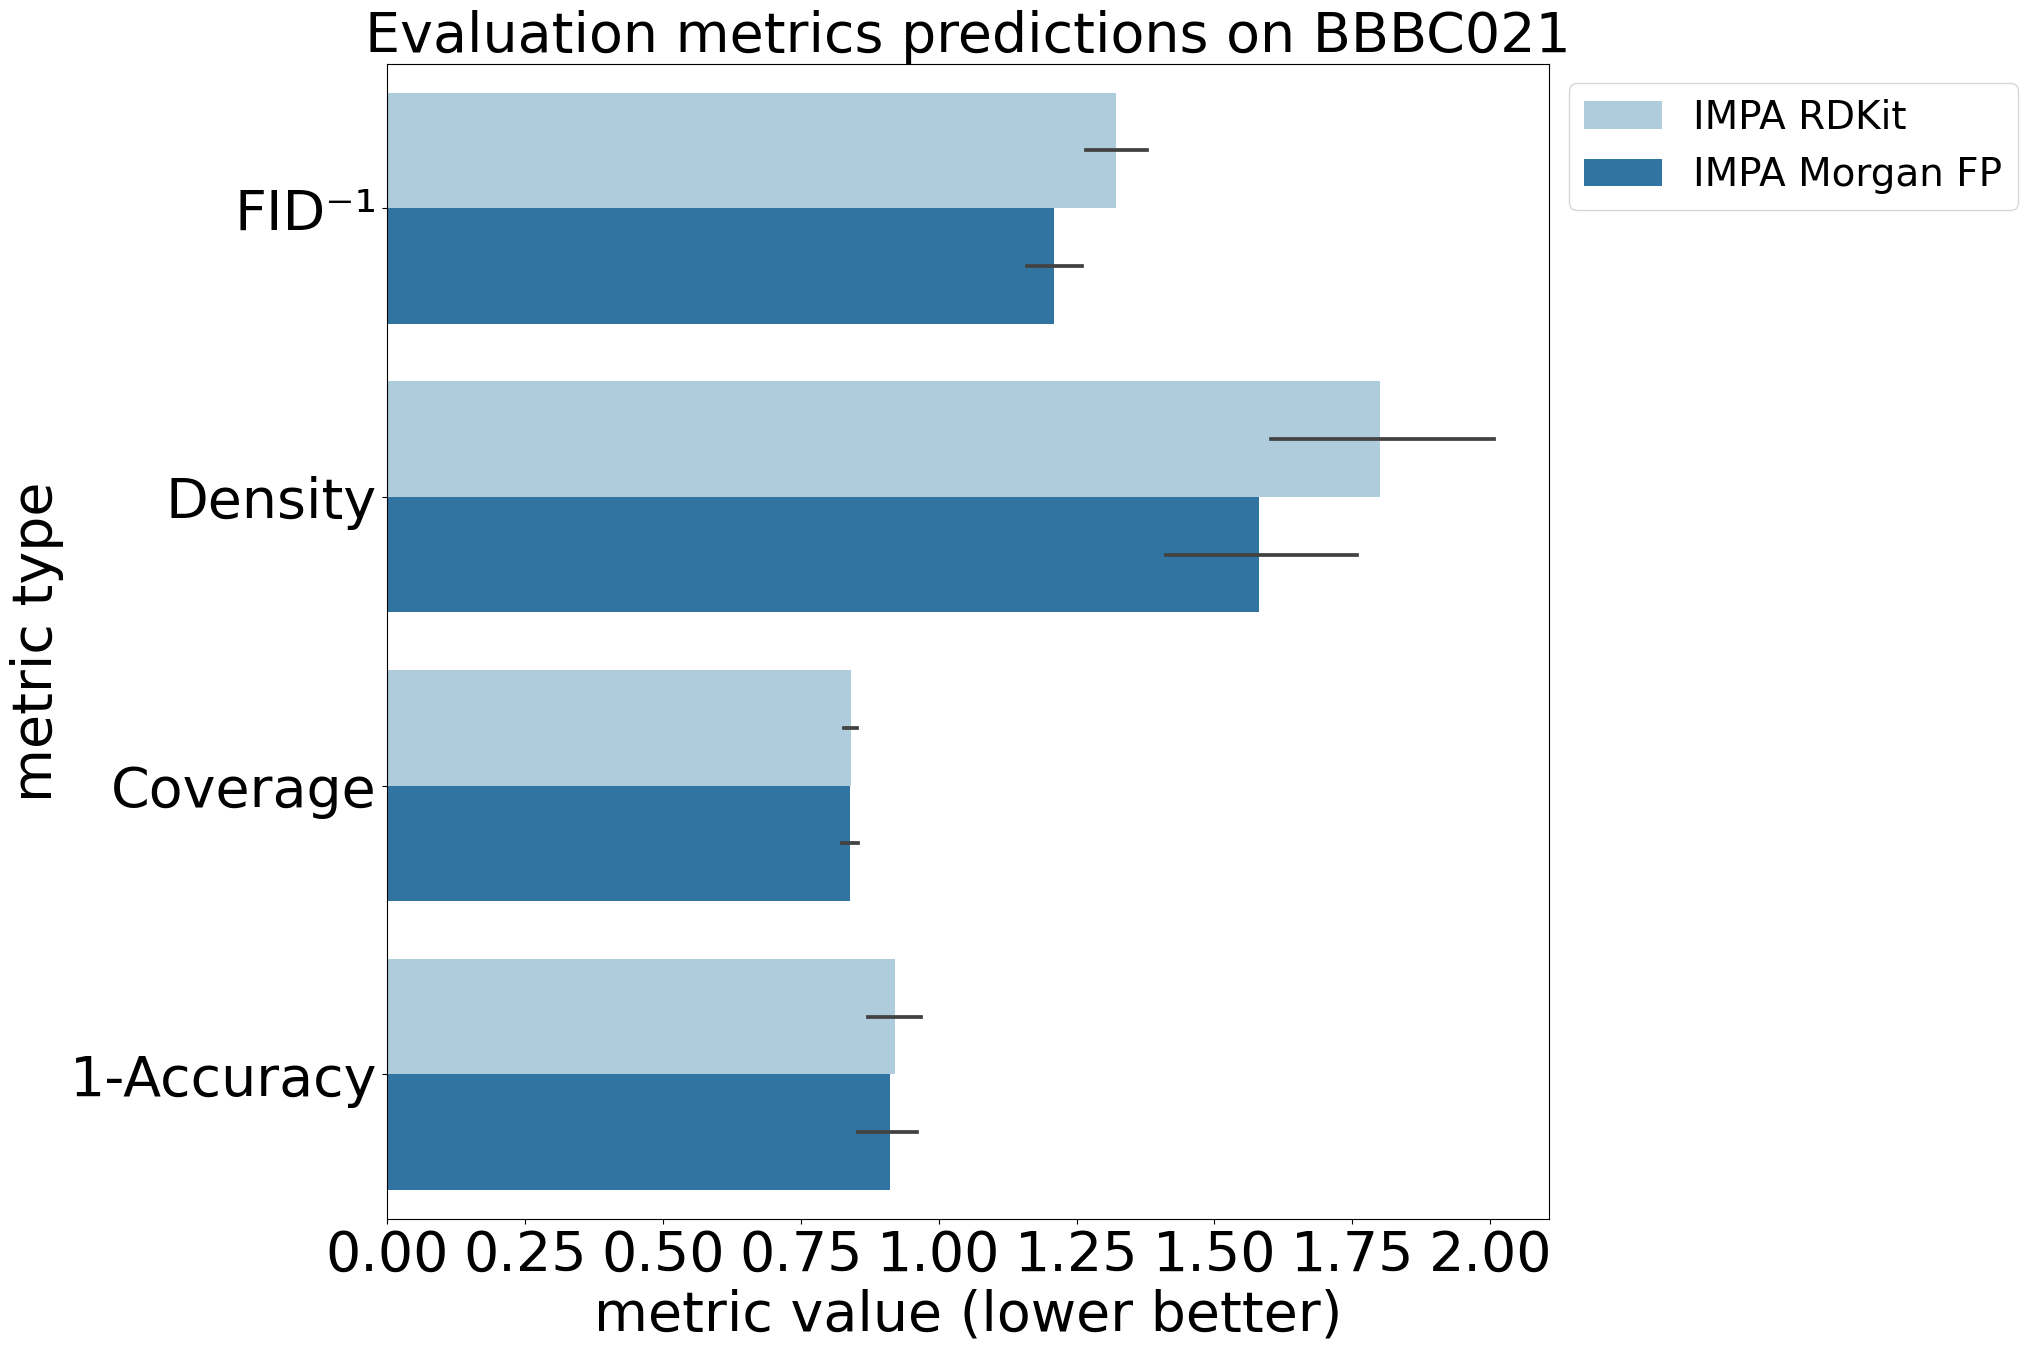

In [109]:
plot_results(fingerprint_comparison)

## COMPARE WITH STARGANV2

In [110]:
stargan_comparison = pd.concat([metric_IMPA_rdkit, metrics_starGANv2])

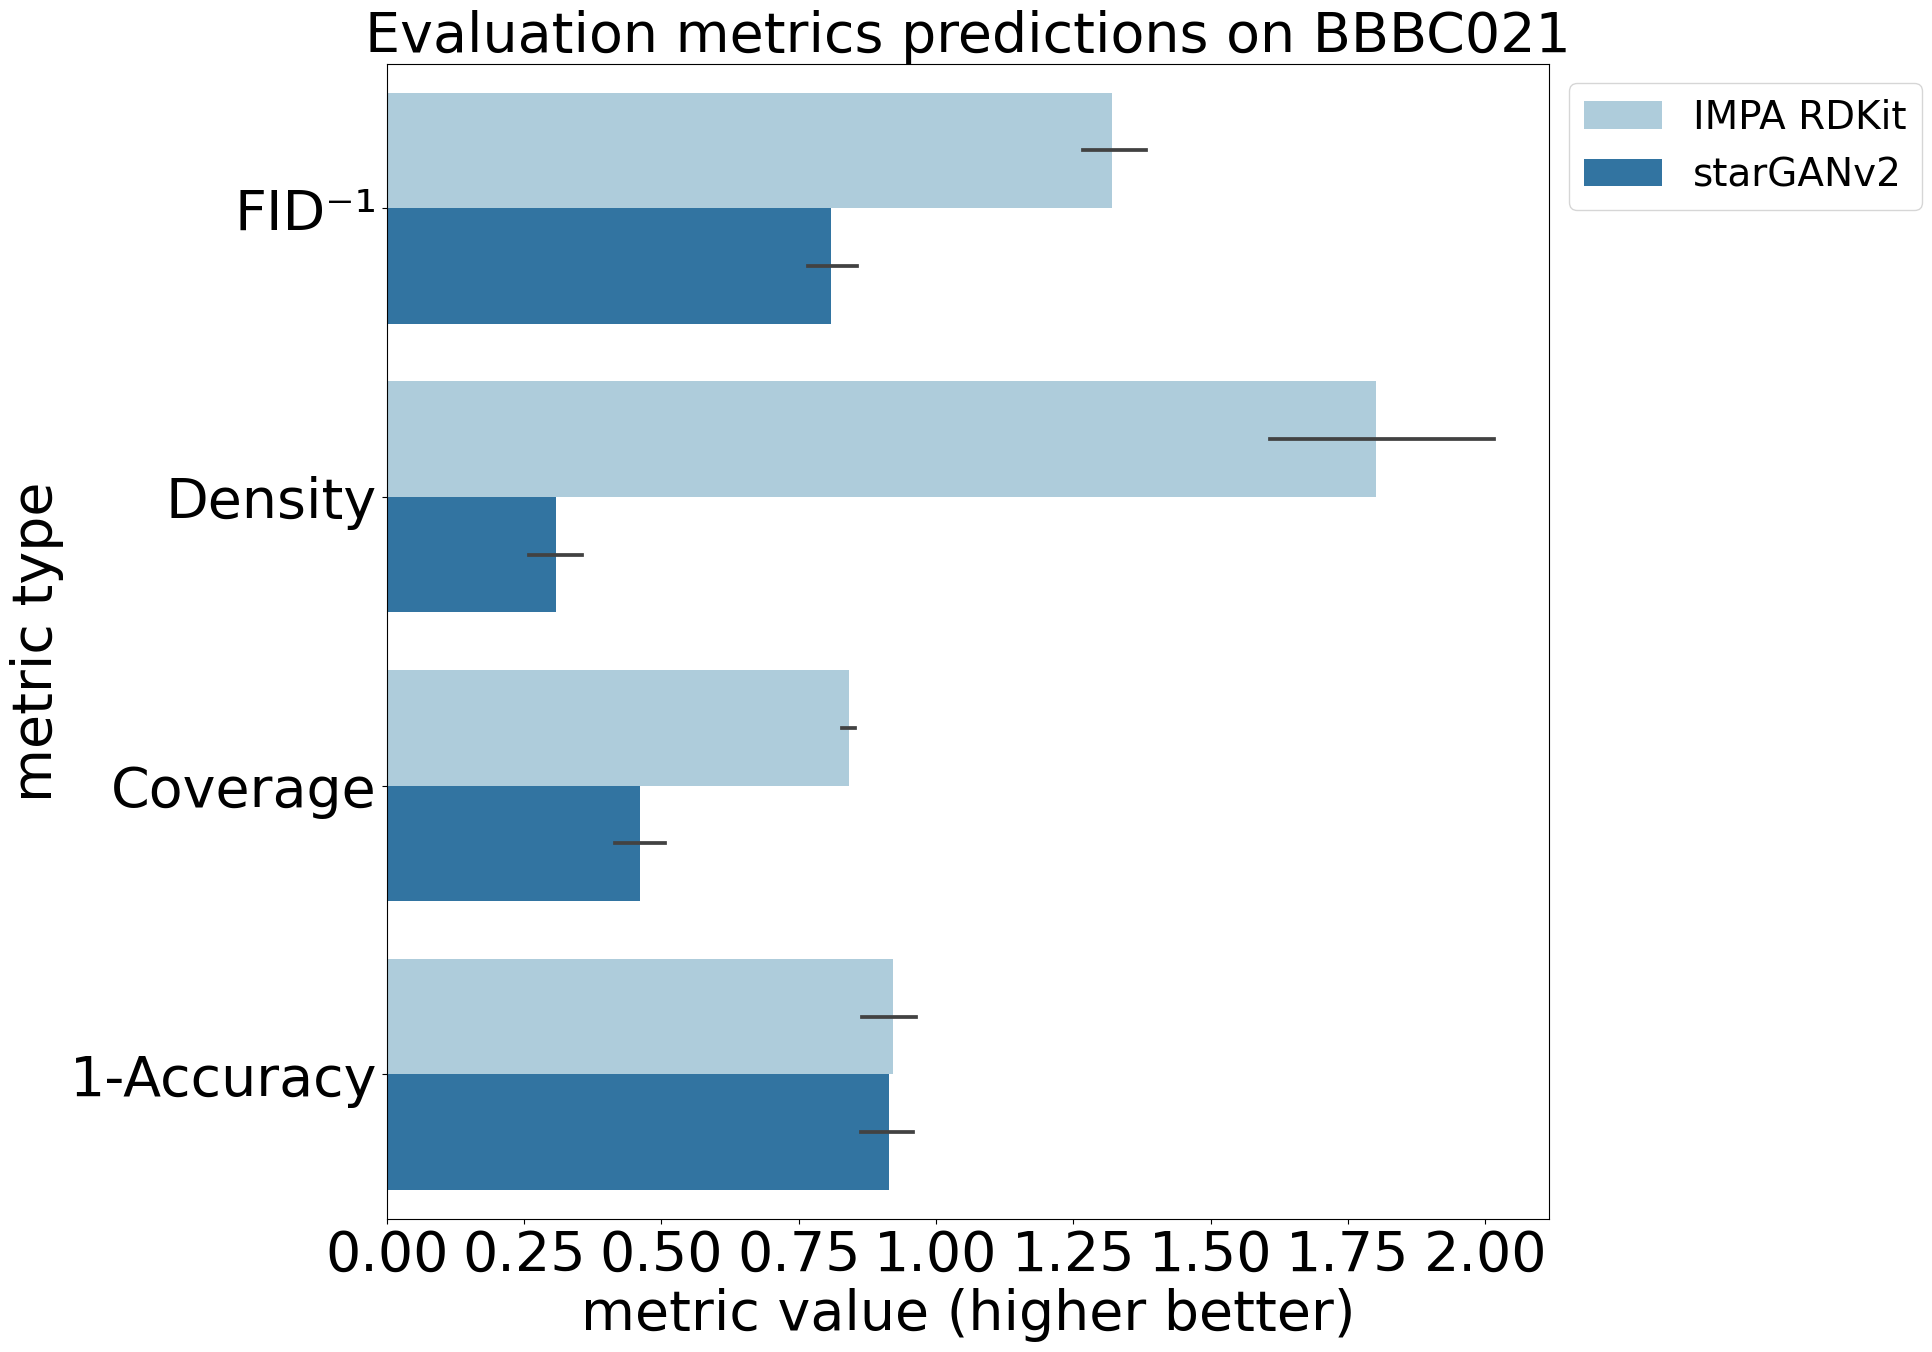

In [113]:
plot_results(stargan_comparison)